# Get Embeddings Metadata Exploration

In [2]:
"""Get Embeddings Metadata Exploration

Structure:
    1. Imports, Variables, Functions
    2. Load Data
    3. Plot 
"""

# 1. Imports, Variables, Functions
# imports
import pickle, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import anndata as ad, os, sys
from tqdm import tqdm
import seaborn as sns

# variables
pp_data = "pp_data-24-10-06-01"

metadata_path = "../data/%s/metadata.pkl" % pp_data
adata_path = "../data/%s/data.h5ad" % pp_data
output_dir = "../data/%s/data_analysis/" % pp_data

if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# functions
def get_diseases_with_n_datasets(obs: pd.DataFrame, n: int) -> set:
    validation_diseases = set()
    for disease in tqdm(obs["disease_study"].unique()):
        QUERY = "disease == @disease"
        _df_query = obs.query(QUERY)

        if _df_query["dataset"].nunique() >= n:
            validation_diseases.add(disease)

    return validation_diseases


# 2. Load Data
with open(metadata_path, "rb") as f:
    metadata = pickle.load(f)

adata = ad.read_h5ad(adata_path, backed="r")  # parameters: backed='r' to read from disk

# Access other attributes without loading adata.X
obs = adata.obs

# 3. Plot
# get how many datasets, de signatures, control and disease samples

print("REPORT FOR FILTER 1 HUMAN & RNA-SEQ, MICROARRAY ")
print("Number of datasets:", obs["dataset"].nunique())
print("Number of DE signatures:", len(set([id.split(";")[0] for id in obs["ids"]])))
print("Number of diseases:", obs["disease_study"].nunique())
print(
    "Number of control samples:",
    len([id.split(";")[2] for id in obs["ids"] if id.split(";")[2] == "Control"]),
)
print(
    "Number of disease samples:",
    len([id.split(";")[2] for id in obs["ids"] if id.split(";")[2] != "Control"]),
)
print("Number of diseases w/ 5+ datasets:", len(get_diseases_with_n_datasets(obs, 5)))

# filter by nº of non-nan gene values per sample
threshold = 10000  # at least 10k non-nan gene values per sample

filter_2 = metadata["n_non_nan_gex"] > 10000

obs_f2 = obs[filter_2]

print("REPORT FOR FILTER 2 10k NON-NAN GENE VALUES")
print("Number of datasets:", obs_f2["dataset"].nunique())
print("Number of DE signatures:", len(set([id.split(";")[0] for id in obs_f2["ids"]])))
print("Number of diseases:", obs_f2["disease_study"].nunique())
print(
    "Number of control samples:",
    len([id.split(";")[2] for id in obs_f2["ids"] if id.split(";")[2] == "Control"]),
)
print(
    "Number of disease samples:",
    len([id.split(";")[2] for id in obs_f2["ids"] if id.split(";")[2] != "Control"]),
)
print(
    "Number of diseases w/ 5+ datasets:", len(get_diseases_with_n_datasets(obs_f2, 5))
)


df_results = pd.DataFrame(
    {
        "Filtering": ["Human & RNA-Seq or Microarray", ">=10k Protein Coding Genes"],
        "Nº Datasets": [obs["dataset"].nunique(), obs_f2["dataset"].nunique()],
        "Nº Diseases": [
            obs["disease_study"].nunique(),
            obs_f2["disease_study"].nunique(),
        ],
        "Nº Diseases 5+ Datasets": [
            len(get_diseases_with_n_datasets(obs, 5)),
            len(get_diseases_with_n_datasets(obs_f2, 5)),
        ],
        "Nº Control Samples": [
            len(
                [id.split(";")[2] for id in obs["ids"] if id.split(";")[2] == "Control"]
            ),
            len(
                [
                    id.split(";")[2]
                    for id in obs_f2["ids"]
                    if id.split(";")[2] == "Control"
                ]
            ),
        ],
        "Nº Disease Samples": [
            len(
                [id.split(";")[2] for id in obs["ids"] if id.split(";")[2] != "Control"]
            ),
            len(
                [
                    id.split(";")[2]
                    for id in obs_f2["ids"]
                    if id.split(";")[2] != "Control"
                ]
            ),
        ],
        "Nº DE Signatures": [
            len(set([id.split(";")[0] for id in obs["ids"]])),
            len(set([id.split(";")[0] for id in obs_f2["ids"]])),
        ],
    }
)

df_results

REPORT FOR FILTER 1 HUMAN & RNA-SEQ, MICROARRAY 
Number of datasets: 2155
Number of DE signatures: 4415
Number of diseases: 86
Number of control samples: 46351
Number of disease samples: 57012


100%|██████████| 86/86 [00:00<00:00, 675.60it/s]

Number of diseases w/ 5+ datasets: 86
REPORT FOR FILTER 2 10k NON-NAN GENE VALUES
Number of datasets: 1527
Number of DE signatures: 2953
Number of diseases: 85
Number of control samples: 38826


Number of disease samples: 48177


100%|██████████| 85/85 [00:00<00:00, 718.92it/s]


Number of diseases w/ 5+ datasets: 77


100%|██████████| 85/85 [00:00<00:00, 741.43it/s]


,Filtering,Nº Datasets,Nº Diseases,Nº Diseases 5+ Datasets,Nº Control Samples,Nº Disease Samples,Nº DE Signatures
0,Human & RNA-Seq or Microarray,2155,86,86,46351,57012,4415
1,>=10k Protein Coding Genes,1527,85,77,38826,48177,2953


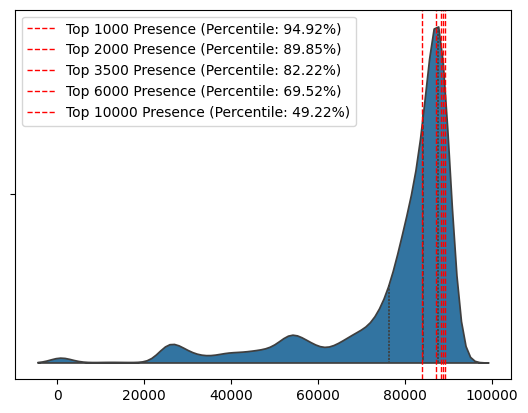

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

presences = [1000, 2000, 3500, 6000, 10000]

# Example metadata
n_non_nan_genes = metadata["n_non_nan_genes"]

# Violin plot
sns.violinplot(x=n_non_nan_genes, inner="quartile", split=True)

# Calculate the presence threshold
presences_vals = list()
for presence in presences:
    presence_thr = np.sort(metadata["n_non_nan_genes"])[::-1][presence]
    percentile_value = stats.percentileofscore(n_non_nan_genes, presence_thr)
    presences_vals.append((presence, presence_thr, percentile_value))

# Draw vertical lines for presence threshold
for presence_val in presences_vals:
    plt.vlines(
        presence_val[1],
        ymin=0,
        ymax=1,
        color="red",
        label=f"Top {presence_val[0]} Presence (Percentile: {presence_val[2]:.2f}%)",
        linestyle="--",
        linewidth=1,
        transform=plt.gca().get_xaxis_transform(),
    )


# Show legend and plot
plt.legend()
plt.show()

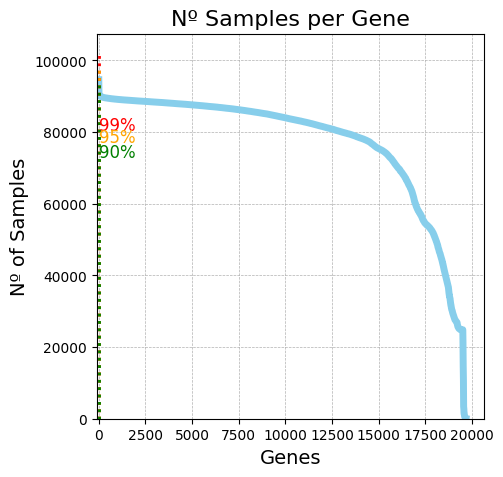

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# sort data
metadata["n_non_nan_genes"].sort()


# Sample data for demonstration
x = list(range(len(metadata["n_non_nan_genes"])))
y = metadata["n_non_nan_genes"][::-1]

# Convert to a line plot
plt.figure(figsize=(5, 5))
plt.plot(x, y, color="skyblue", label="Number of non-NaN genes", linewidth=5)

# Calculate thresholds
thresholds = [0.99, 0.95, 0.90]
colors = ["red", "orange", "green"]

for i, threshold in enumerate(thresholds):

    threshold_value = metadata["n_gex"] * threshold

    # Find the index where y meets or exceeds the threshold
    indices = np.where(y >= threshold_value)[0]

    if len(indices) == 0:
        threshold_index = -1
    else:
        threshold_index = indices[-1]

    plt.hlines(
        threshold_value,
        0,
        threshold_index,
        color=colors[i],
        linestyles="dotted",
        linewidth=2,
    )
    plt.vlines(
        threshold_index,
        0,
        threshold_value,
        color=colors[i],
        linestyles="dotted",
        linewidth=2,
    )

    # Annotate the vertical line, adjust position dynamically if needed
    plt.text(
        threshold_index + 1,
        threshold_value * 0.8,
        f"{int(threshold * 100)}%",
        color=colors[i],
        fontsize=12,
        va="center",
    )

# Add a title and labels
plt.title("Nº Samples per Gene", fontsize=16)
plt.xlabel("Genes", fontsize=14)
plt.ylabel("Nº of Samples", fontsize=14)

# Add a legend
# plt.legend()

# Add lim
plt.ylim(
    0,
)
plt.xlim(
    -100,
)


# Add grid for better readability
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.savefig(os.path.join(output_dir, "gene_presence.png"), dpi=300, bbox_inches="tight")

0
0
5


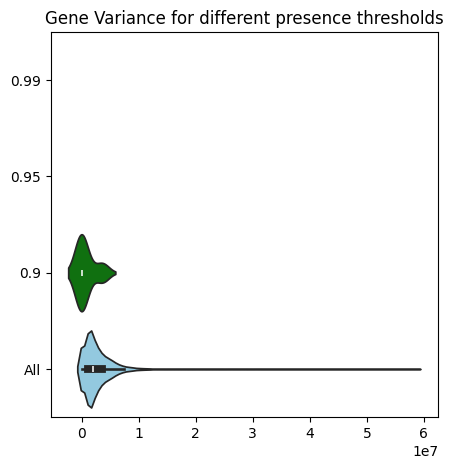

In [5]:
import seaborn as sns

thresholds = [0.99, 0.95, 0.90]

data = dict()
for i in thresholds:
    threshold_value = metadata["n_gex"] * i
    mask = metadata["n_non_nan_genes"] >= threshold_value
    values = metadata["genes_std"][mask]
    values = values[~np.isnan(values)]
    data[i] = values
    print(len(values))


data["All"] = metadata["genes_std"][~np.isnan(metadata["genes_std"])]

# plot gene variance
plt.figure(figsize=(5, 5))
plt.title("Gene Variance for different presence thresholds")
sns.violinplot(data=data, orient="h", palette=["red", "orange", "green", "skyblue"])

plt.savefig(os.path.join(output_dir, "gene_variance.png"), dpi=300, bbox_inches="tight")

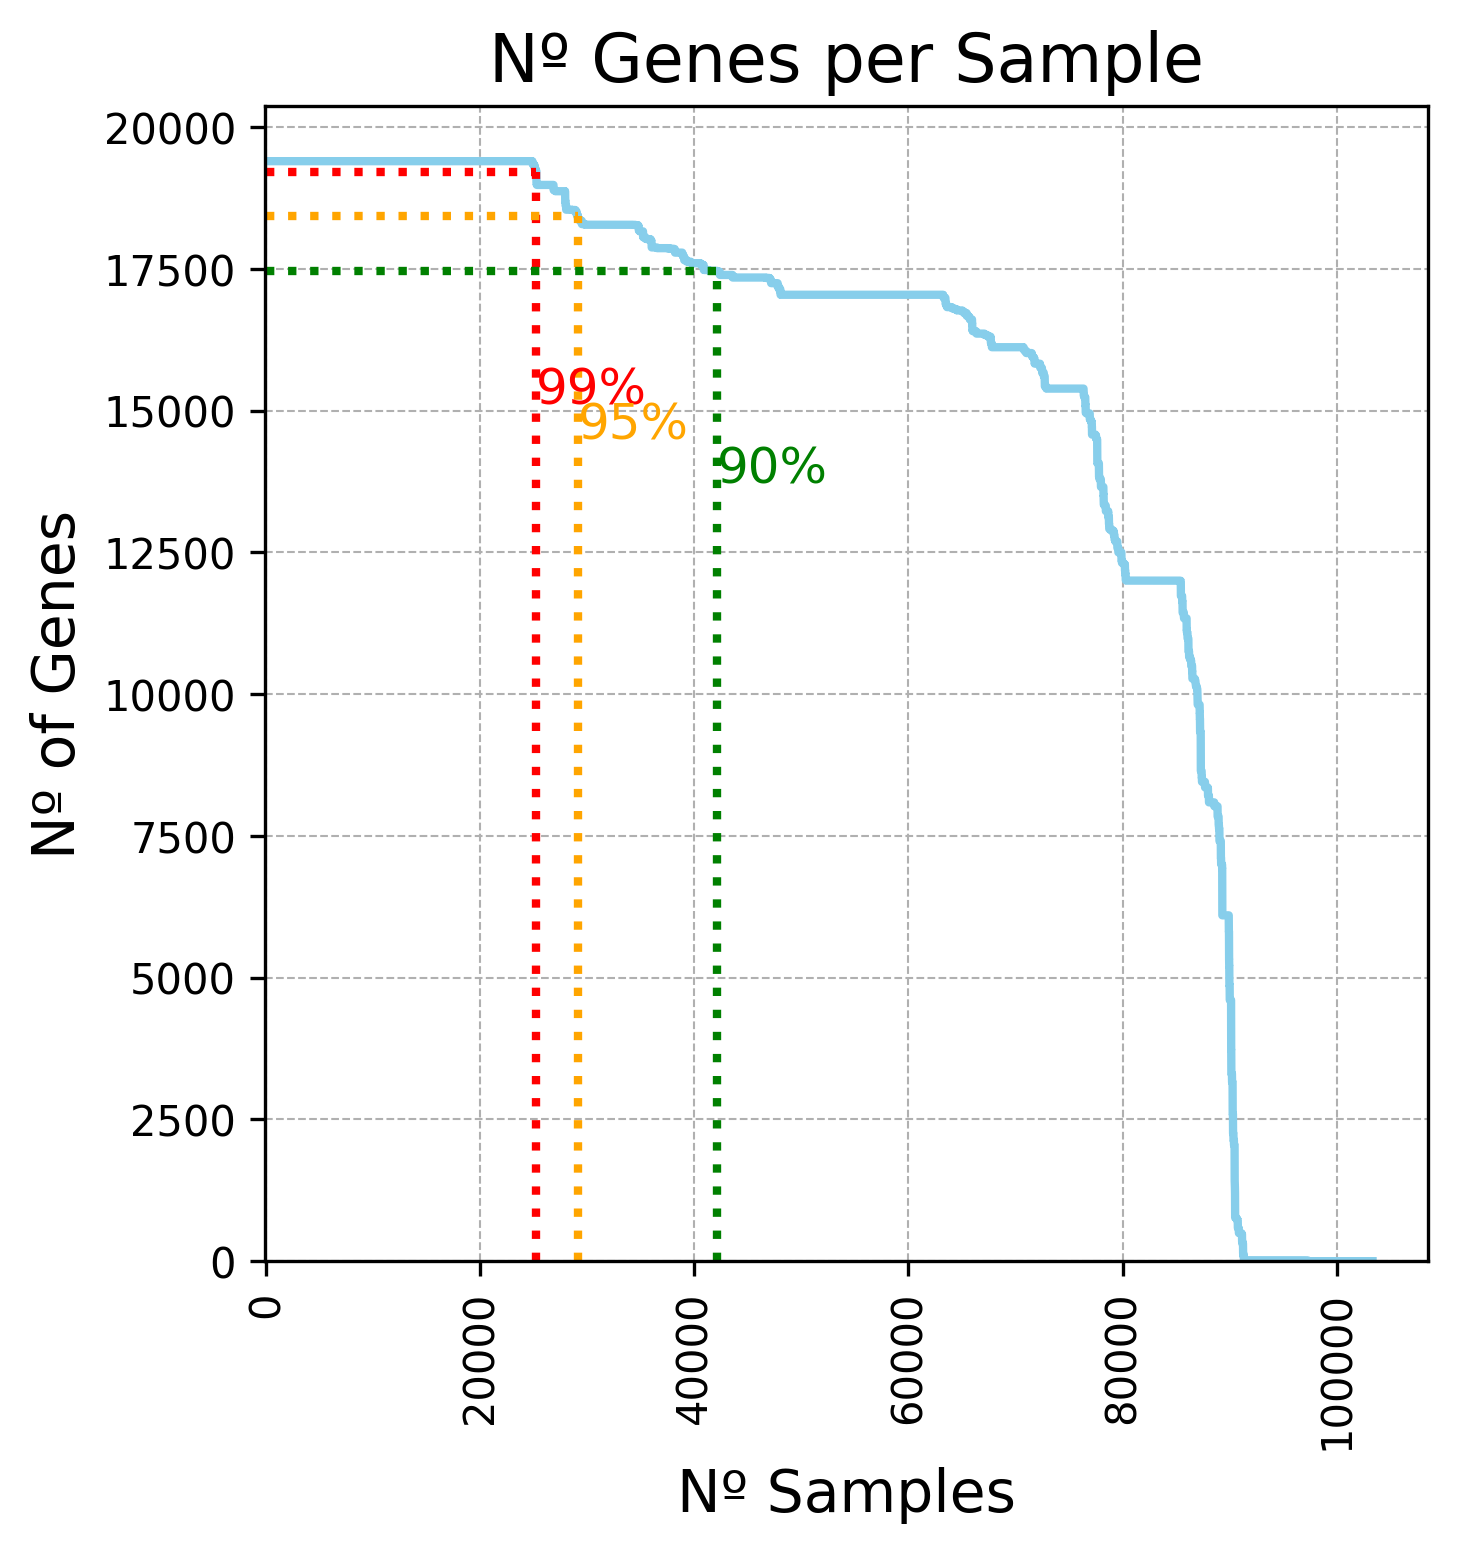

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime


# sort data
metadata["n_non_nan_gex"].sort()


# Sample data for demonstration
x = np.array(list(range(len(metadata["n_non_nan_gex"]))))
y = metadata["n_non_nan_gex"][::-1]

# Convert to a line plot
plt.figure(figsize=(5, 5), dpi=300)
plt.plot(x, y, color="skyblue", label="Number of non-NaN genes", linewidth=2)

# Calculate thresholds
thresholds = [0.99, 0.95, 0.90]
colors = ["red", "orange", "green"]


for i, threshold in enumerate(thresholds):

    y_value_thr = max(y) * threshold
    y_value_idx = np.argwhere(y >= y_value_thr)[-1][0]

    y_value = y[y_value_idx]
    x_value = x[y_value_idx]

    plt.vlines(x_value, 0, y_value, color=colors[i], linestyles="dotted", linewidth=2)
    plt.hlines(y_value, 0, x_value, color=colors[i], linestyles="dotted", linewidth=2)

    plt.text(
        x_value + 1,
        y_value * 0.8,
        f"{int(threshold * 100)}%",
        color=colors[i],
        fontsize=12,
        va="center",
    )


# Add a title and labels
plt.title("Nº Genes per Sample", fontsize=16)
plt.xlabel("Nº Samples", fontsize=14)
plt.ylabel("Nº of Genes", fontsize=14)

# Add a legend
# plt.legend()

# Add lim
plt.ylim(
    0,
)
plt.xlim(
    -100,
)

plt.xticks(rotation=90)


# Add grid for better readability
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# # Show the plot
# plt.savefig(
#     os.path.join(output_dir, "sample_presence.png"), dpi=300, bbox_inches="tight"
# )

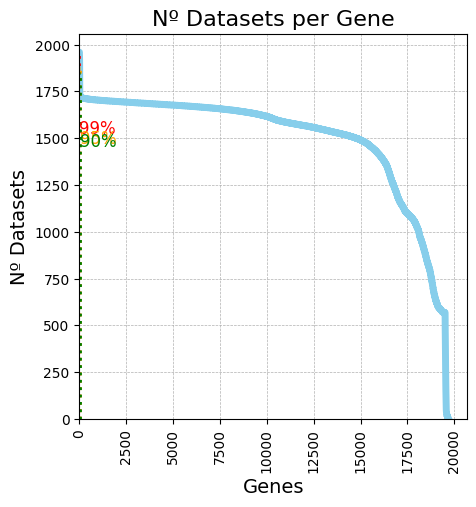

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# sort data
metadata["n_non_nan_dis_dt_genes"].sort()


# Sample data for demonstration
x = np.array(list(range(len(metadata["n_non_nan_dis_dt_genes"]))))
y = metadata["n_non_nan_dis_dt_genes"][::-1]

# Convert to a line plot
plt.figure(figsize=(5, 5))
plt.plot(x, y, color="skyblue", label="Number of non-NaN genes", linewidth=5)

# Calculate thresholds
thresholds = [0.99, 0.95, 0.90]
colors = ["red", "orange", "green"]


for i, threshold in enumerate(thresholds):

    y_value_thr = max(y) * threshold
    y_value_idx = np.argwhere(y >= y_value_thr)[-1][0]

    y_value = y[y_value_idx]
    x_value = x[y_value_idx]

    plt.vlines(x_value, 0, y_value, color=colors[i], linestyles="dotted", linewidth=2)
    plt.hlines(y_value, 0, x_value, color=colors[i], linestyles="dotted", linewidth=2)

    plt.text(
        x_value + 1,
        y_value * 0.8,
        f"{int(threshold * 100)}%",
        color=colors[i],
        fontsize=12,
        va="center",
    )


# Add a title and labels
plt.title("Nº Datasets per Gene", fontsize=16)
plt.xlabel("Genes", fontsize=14)
plt.ylabel("Nº Datasets", fontsize=14)

# Add lim
plt.ylim(
    0,
)
plt.xlim(
    0,
)

plt.xticks(rotation=90)


# Add grid for better readability
plt.grid(True, which="both", linestyle="--", linewidth=0.5)


# Show the plot
plt.savefig(
    os.path.join(output_dir, "datasets_per_gene.png"), dpi=300, bbox_inches="tight"
)

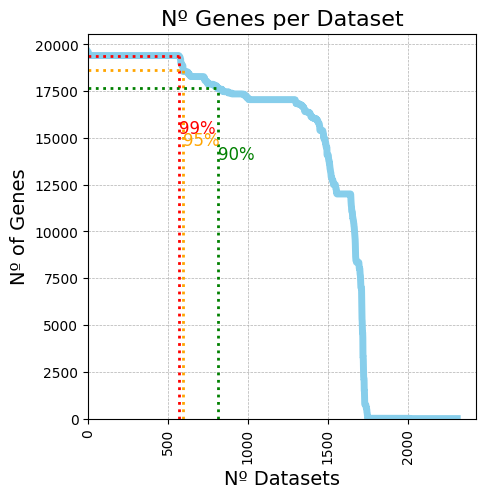

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# sort data
metadata["n_non_nan_dis_dt_row"].sort()


# Sample data for demonstration
x = np.array(list(range(len(metadata["n_non_nan_dis_dt_row"]))))
y = metadata["n_non_nan_dis_dt_row"][::-1]

# Convert to a line plot
plt.figure(figsize=(5, 5))
plt.plot(x, y, color="skyblue", label="Number of non-NaN genes", linewidth=5)

# Calculate thresholds
thresholds = [0.99, 0.95, 0.90]
colors = ["red", "orange", "green"]


for i, threshold in enumerate(thresholds):

    y_value_thr = max(y) * threshold
    y_value_idx = np.argwhere(y >= y_value_thr)[-1][0]

    y_value = y[y_value_idx]
    x_value = x[y_value_idx]

    plt.vlines(x_value, 0, y_value, color=colors[i], linestyles="dotted", linewidth=2)
    plt.hlines(y_value, 0, x_value, color=colors[i], linestyles="dotted", linewidth=2)

    plt.text(
        x_value + 1,
        y_value * 0.8,
        f"{int(threshold * 100)}%",
        color=colors[i],
        fontsize=12,
        va="center",
    )


# Add a title and labels
plt.title("Nº Genes per Dataset", fontsize=16)
plt.xlabel("Nº Datasets", fontsize=14)
plt.ylabel("Nº of Genes", fontsize=14)

# Add lim
plt.ylim(
    0,
)
plt.xlim(
    0,
)

plt.xticks(rotation=90)


# Add grid for better readability
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Show the plot
plt.savefig(
    os.path.join(output_dir, "genes_per_dataset.png"), dpi=300, bbox_inches="tight"
)

# Nº of Samples

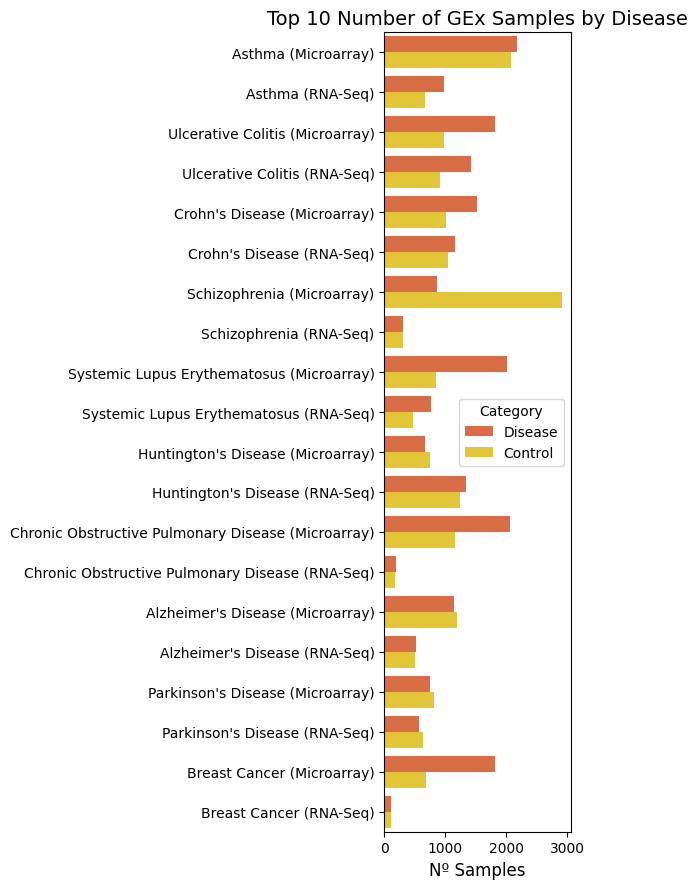

In [55]:
import seaborn as sns
from matplotlib import pyplot as plt

k = 10
irb_colors = [
    "#ffd81cff",
    "#f6972dff",
    "#f2612dff",
    "#574270ff",
    "#00589bff",
    "#002f58ff",
]

top_k_diseases = adata.obs["disease_study"].value_counts()[:k].index.to_list()


data = list()

for disease in top_k_diseases:
    for library in ["Microarray", "RNA-Seq"]:

        QUERY = "disease_study == @disease & library == @library"
        df_query = adata.obs.query(QUERY)
        n_controls = len([x for x in df_query["ids"] if x.split(";")[2] == "Control"])
        n_diseases = len([x for x in df_query["ids"] if x.split(";")[2] != "Control"])

        data.append(
            {
                "Counts": n_diseases,
                "Disease": "%s (%s)" % (disease, library),
                "Category": "Disease",
            }
        )

        data.append(
            {
                "Counts": n_controls,
                "Disease": "%s (%s)" % (disease, library),
                "Category": "Control",
            }
        )


# Transform the DataFrame to long format
df_data = pd.DataFrame(data)

# Plotting with seaborn
plt.figure(figsize=(6, 9))
sns.barplot(
    data=df_data,
    y="Disease",
    x="Counts",
    hue="Category",
    palette=[irb_colors[2], irb_colors[0]],
    orient="y",
)

# Adding labels and title
plt.xlabel("Nº Samples", fontsize=12)
plt.ylabel("", fontsize=12)
plt.title(f"Top {k} Number of GEx Samples by Disease", fontsize=14)
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "n_samples.png"), dpi=300, bbox_inches="tight")

disease_study
Asthma    5908
Name: count, dtype: int64

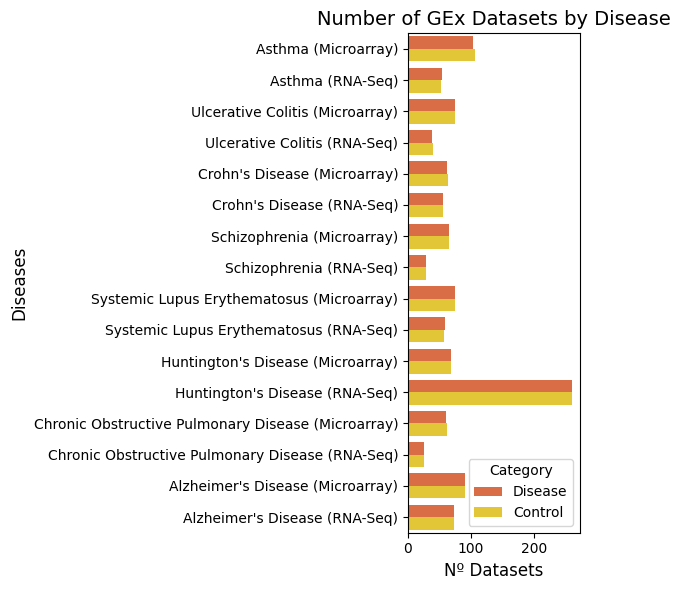

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt

k = 8
irb_colors = [
    "#ffd81cff",
    "#f6972dff",
    "#f2612dff",
    "#574270ff",
    "#00589bff",
    "#002f58ff",
]
top_k_diseases = adata.obs["disease_study"].value_counts()[:k].index.to_list()

data = list()
for disease in top_k_diseases:
    for library in ["Microarray", "RNA-Seq"]:

        QUERY = "disease_study == @disease & library == @library"
        df_query = adata.obs.query(QUERY)

        mask_control = df_query["disease"] == "Control"
        mask_disease = df_query["disease"] != "Control"

        n_controls = df_query[mask_control]["dsaid"].nunique()
        n_diseases = df_query[mask_disease]["dsaid"].nunique()

        data.append(
            {
                "Counts": n_diseases,
                "Disease": "%s (%s)" % (disease, library),
                "Category": "Disease",
            }
        )

        data.append(
            {
                "Counts": n_controls,
                "Disease": "%s (%s)" % (disease, library),
                "Category": "Control",
            }
        )


# Transform the DataFrame to long format
df_data = pd.DataFrame(data)

# Plotting with seaborn
plt.figure(figsize=(6, 6))
sns.barplot(
    data=df_data,
    y="Disease",
    x="Counts",
    hue="Category",
    palette=[irb_colors[2], irb_colors[0]],
    orient="y",
)

# Adding labels and title
plt.xlabel("Nº Datasets", fontsize=12)
plt.ylabel("Diseases", fontsize=12)
plt.title("Number of GEx Datasets by Disease", fontsize=14)
plt.xticks(rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "n_datasets.png"), dpi=300, bbox_inches="tight")

## Presence & Variance Analysis

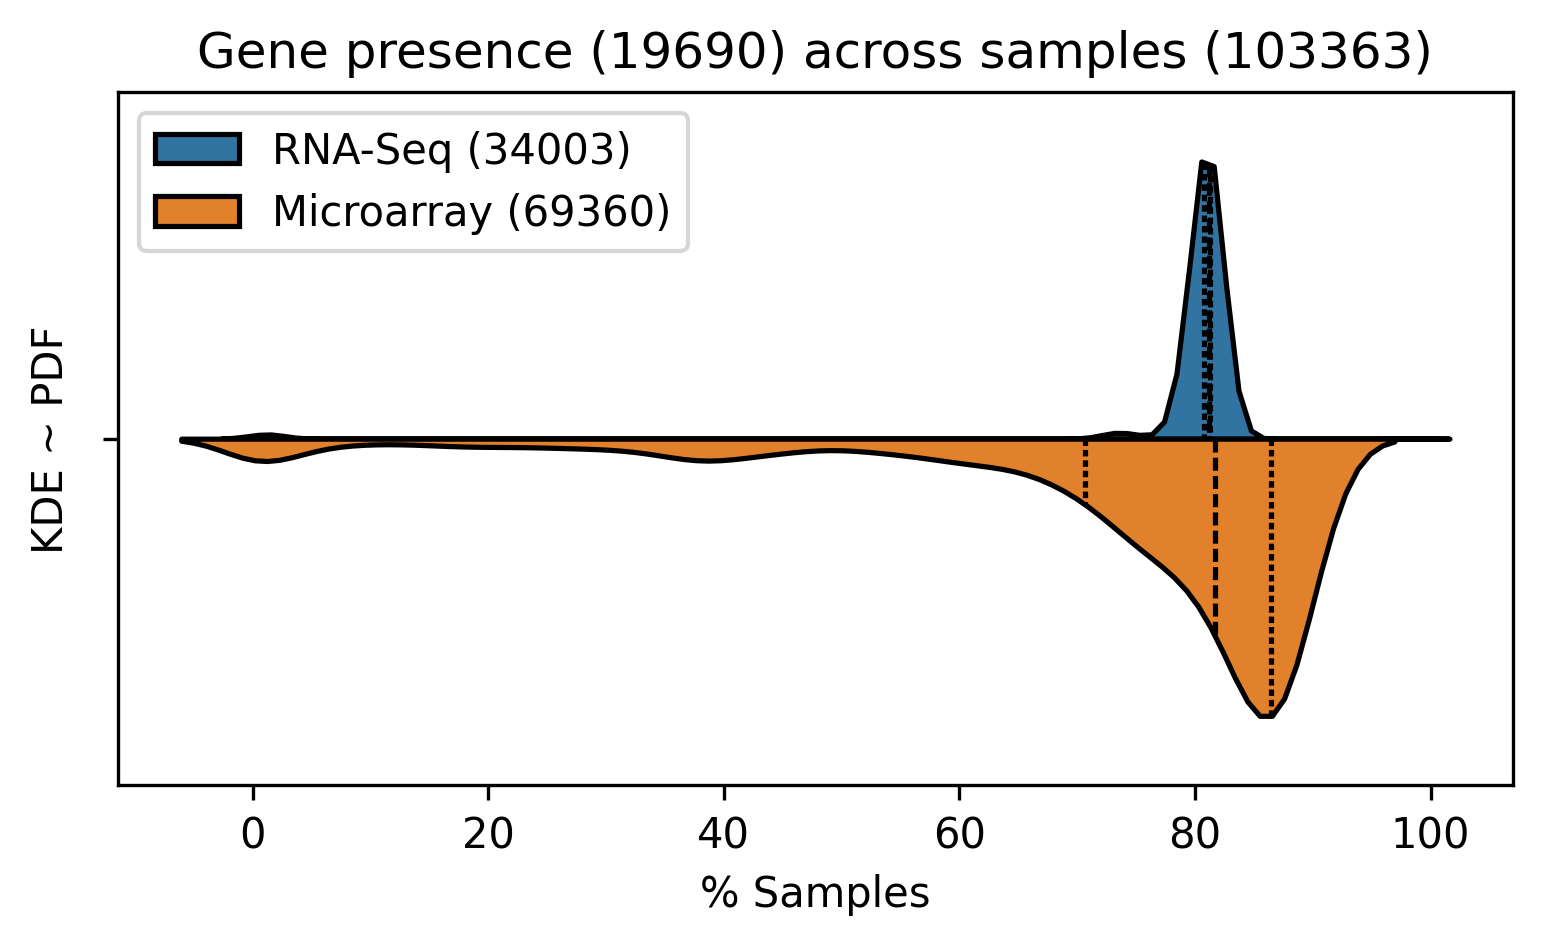

In [45]:
# Plot presence of of gene across samples

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3), dpi=300)

data = {"Category": list(), "Counts": list()}
for library in ["RNA-Seq", "Microarray"]:
    mask = adata.obs["library"] == library
    n_non_nans = np.sum(~np.isnan(adata.X[mask]), axis=0) / adata.X[mask].shape[0] * 100
    data["Category"].extend(["%s (%s)" % (library, np.sum(mask))] * len(n_non_nans))
    data["Counts"].extend(n_non_nans)

df_data = pd.DataFrame(data)

sns.violinplot(
    df_data,
    x="Counts",
    orient="h",
    # inner_kws=dict(box_width=15, whis_width=2, color=".8"),
    hue="Category",
    split=True,
    inner="quartile",
    # color="paleturquoise",
    edgecolor="black",
)

plt.ylabel("KDE ~ PDF")
plt.xlabel("% Samples")

plt.legend()
plt.title(f"Gene presence ({adata.shape[1]}) across samples ({adata.shape[0]})")

plt.savefig(
    os.path.join(output_dir, "presence.png"),
    dpi=300,
    bbox_inches="tight",
)

/home/ddalton/miniconda3/envs/scgpt/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


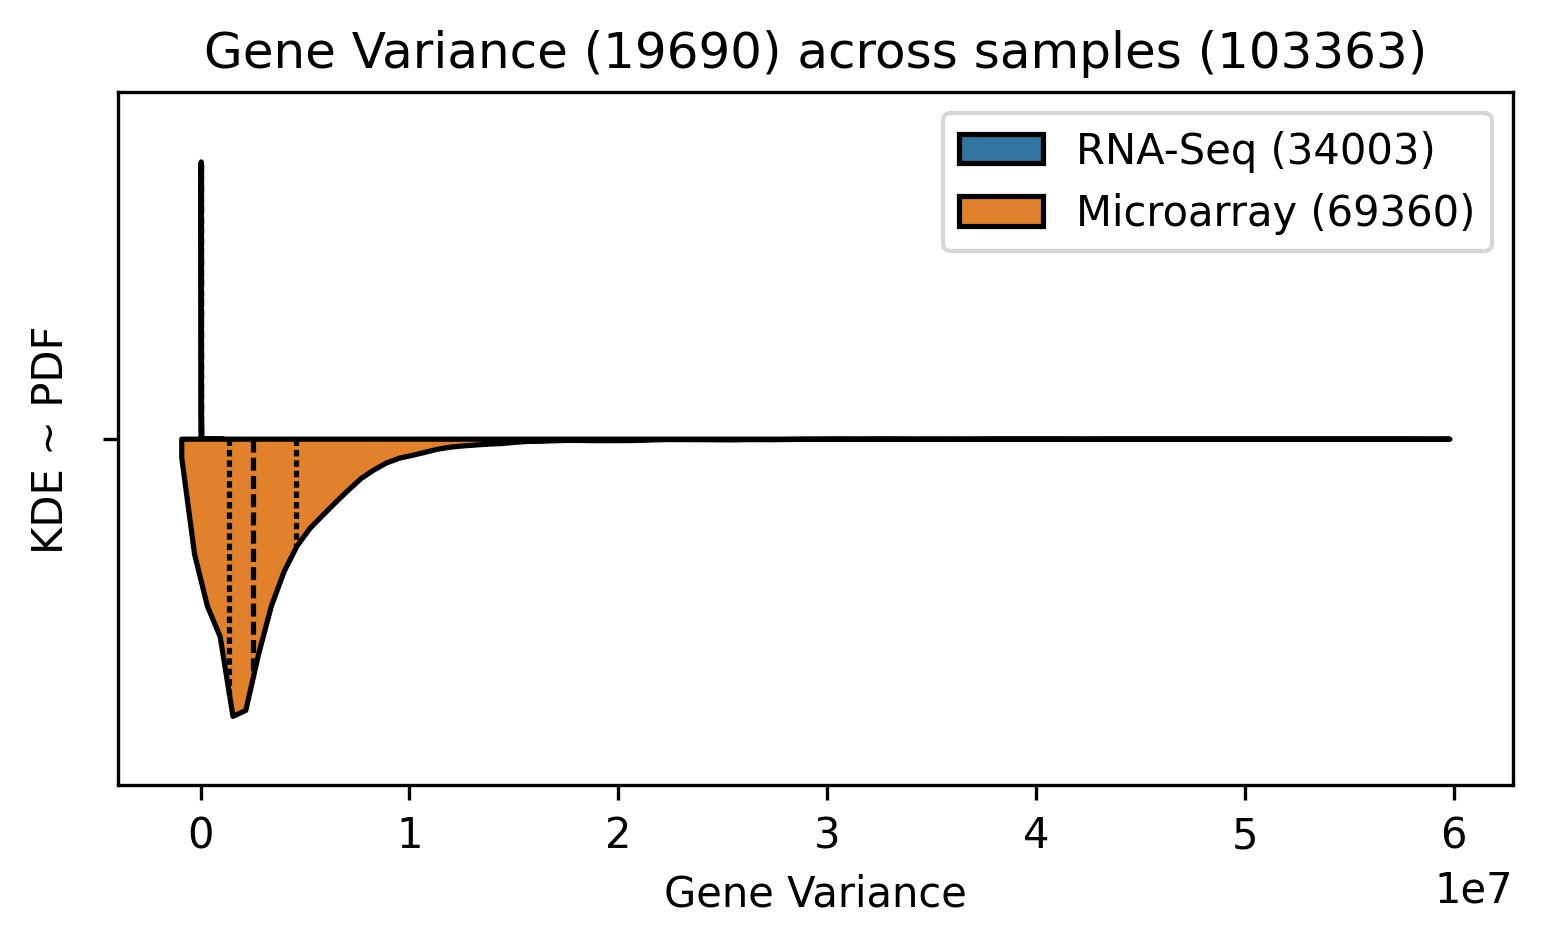

In [46]:
# Plot Gene Variance across samples

import matplotlib.pyplot as plt

data = {"Category": list(), "Counts": list()}
for library in ["RNA-Seq", "Microarray"]:
    mask = adata.obs["library"] == library
    n_std = np.nanstd(adata.X[mask], axis=0)
    data["Category"].extend(["%s (%s)" % (library, np.sum(mask))] * len(n_non_nans))
    data["Counts"].extend(n_std)

df_data = pd.DataFrame(data)

presence = 0.95  # gene presence in samples

# filter out the genes with lowest presence
thr_presence = adata.X.shape[0] * presence

plt.figure(figsize=(6, 3), dpi=300)

sns.violinplot(
    data,
    x="Counts",
    orient="h",
    # inner_kws=dict(box_width=15, whis_width=2, color=".8"),
    split=True,
    hue="Category",
    inner="quartile",
    # color="paleturquoise",
    edgecolor="black",
)


plt.ylabel("KDE ~ PDF")
plt.xlabel("Gene Variance")

plt.legend()
plt.title(f"Gene Variance ({adata.shape[1]}) across samples ({adata.shape[0]})")

plt.savefig(
    os.path.join(output_dir, "variance.png"),
    dpi=300,
    bbox_inches="tight",
)

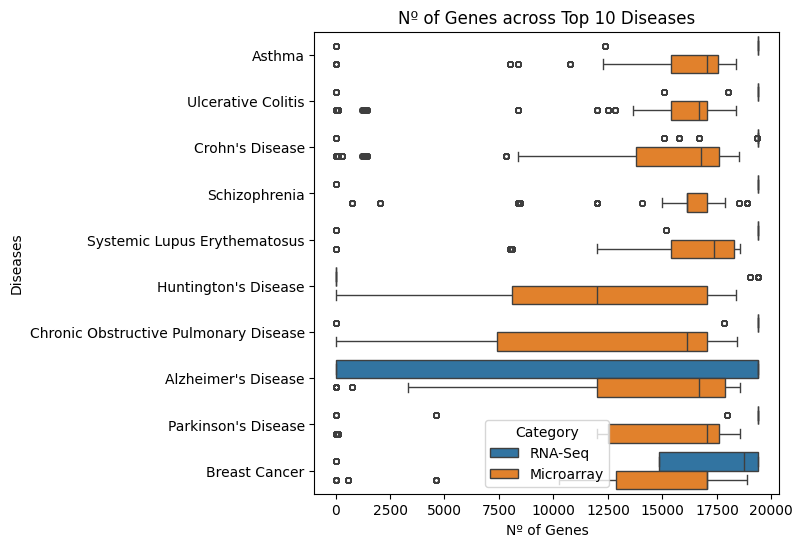

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

k = 10

# Assuming d_data is defined and contains the necessary data
data = {"Labels": list(), "Counts": list(), "Category": list()}

top_k_diseases = adata.obs["disease_study"].value_counts()[:k].index.to_list()


for library in ["RNA-Seq", "Microarray"]:
    for disease in top_k_diseases:
        mask = (adata.obs["library"] == library) & (
            adata.obs["disease_study"] == disease
        )

        n_genes = (~np.isnan(adata.X[mask])).sum(axis=1)

        data["Labels"].extend([disease] * len(n_genes))
        data["Counts"].extend(n_genes)
        data["Category"].extend([library] * len(n_genes))

df_data = pd.DataFrame(data)

labels = adata.obs["disease_study"].to_list()
n_genes = (~np.isnan(adata.X)).sum(axis=1)

flat_genes = []
flat_labels = []
# for label, genes_list in zip(labels, n_genes):
#     flat_genes.extend(genes_list)
#     flat_labels.extend([label] * len(genes_list))

plt.figure(figsize=(6, 6))

# Violin plot
# sns.violinplot(
#     df_data,
#     x="Labels",
#     y="Counts",
#     hue="Category",
#     # palette=[irb_colors[2], irb_colors[4], irb_colors[0]],
#     # split=True,
#     inner="quartile",
# )


sns.boxplot(
    df_data,
    y="Labels",
    x="Counts",
    hue="Category",
    # palette=[irb_colors[2], irb_colors[4], irb_colors[0]],
    # split=True,
    # inner="quartile",
    fliersize=4,
    orient="h",
)

# Adding titles and labels
plt.ylabel("Diseases")
plt.xlabel("Nº of Genes")
plt.xticks(rotation=0)
plt.title(f"Nº of Genes across Top {k} Diseases")
plt.savefig(
    os.path.join(output_dir, "boxplot.n_genes_vs_diseases.png"),
    dpi=300,
    bbox_inches="tight",
)

<Axes: >

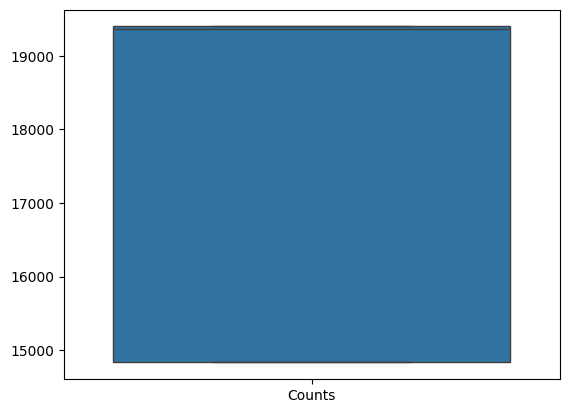

In [46]:
sns.boxplot(
    df_data[(df_data["Labels"] == "Breast Cancer") & (df_data["Category"] == "RNA-Seq")]
)

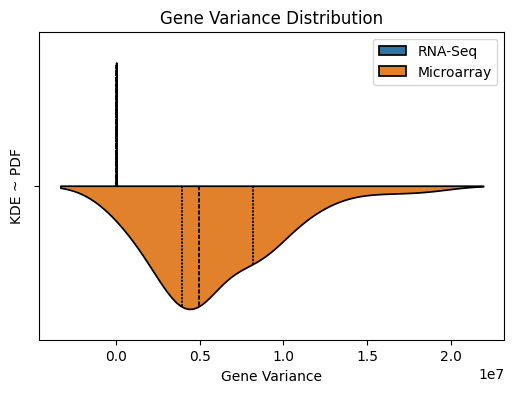

In [52]:
# Plot Gene Variance across samples

presence = 0.99  # gene presence in samples

# filter out the genes with lowest presence
thr_presence = adata.X.shape[0] * presence

import matplotlib.pyplot as plt


data = {"Category": list(), "Counts": list()}
for library in ["RNA-Seq", "Microarray"]:
    mask_l = adata.obs["library"] == library
    mask_p = np.sum(~np.isnan(adata.X), axis=0) > thr_presence
    n_std = np.nanstd(adata.X[mask_l, :][:, mask_p], axis=0)
    data["Category"].extend([library] * len(n_std))
    data["Counts"].extend(n_std)

df_data = pd.DataFrame(data)


plt.figure(figsize=(6, 4))

sns.violinplot(
    data,
    x="Counts",
    orient="h",
    # inner_kws=dict(box_width=15, whis_width=2, color=".8"),
    split=True,
    hue="Category",
    inner="quartile",
    # color="paleturquoise",
    edgecolor="black",
)


plt.ylabel("KDE ~ PDF")
plt.xlabel("Gene Variance")

plt.legend()
plt.title(f"Gene Variance Distribution")

plt.savefig(
    os.path.join(output_dir, "variance.high_presence.png"),
    dpi=300,
    bbox_inches="tight",
)

In [55]:
max(np.nanstd(adata.X[adata.obs["library"] == "Microarray", :], axis=0))

181912977.537882

0           RNA-Seq
1           RNA-Seq
2           RNA-Seq
3           RNA-Seq
4           RNA-Seq
            ...    
16115    Microarray
16116    Microarray
16117    Microarray
16118    Microarray
16119    Microarray
Name: library, Length: 16120, dtype: category
Categories (2, object): ['Microarray', 'RNA-Seq']

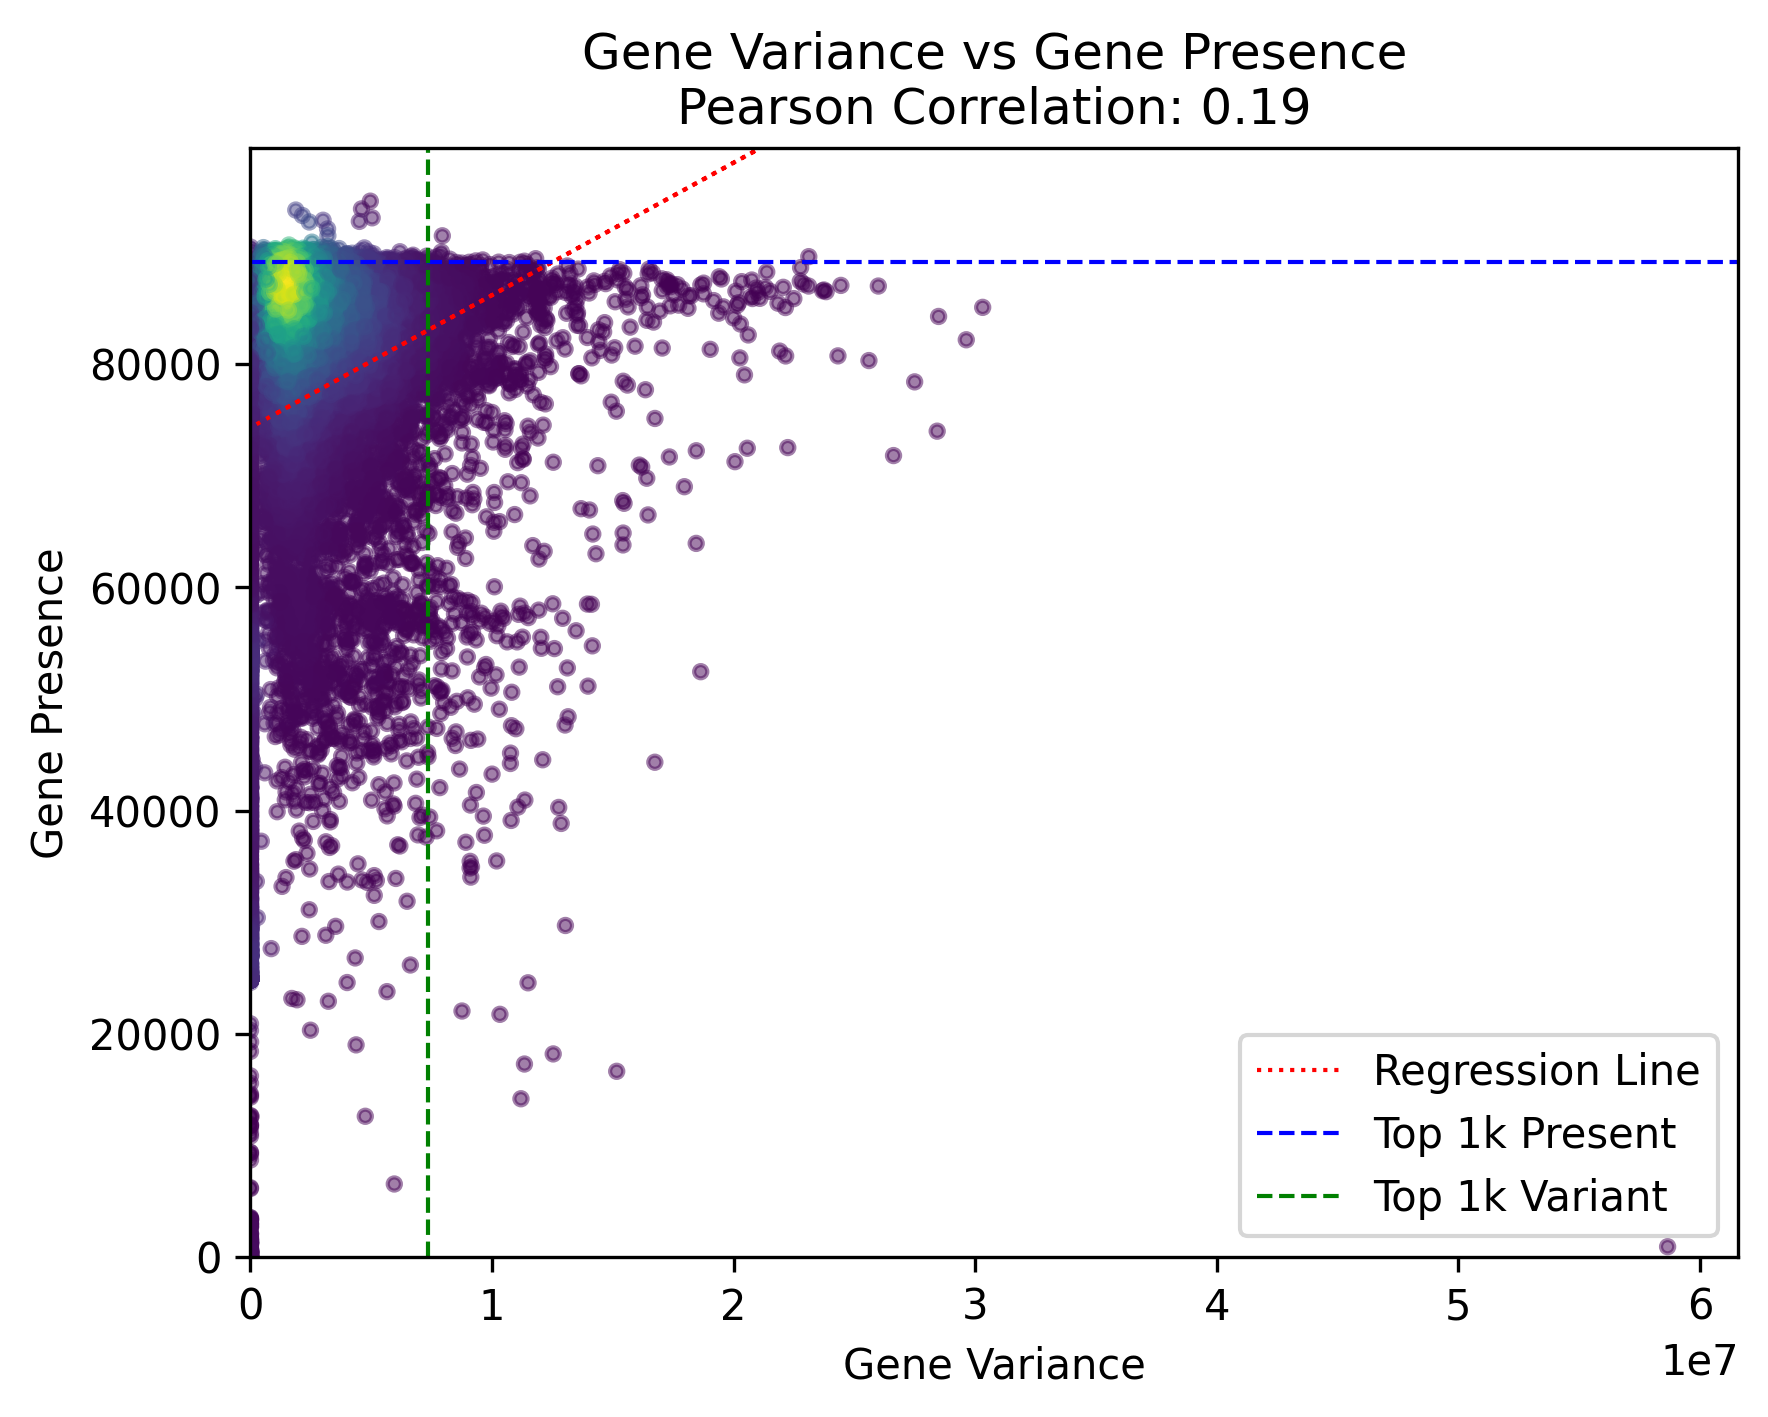

In [58]:
# Plot Gene Vairance vs Gene Presence
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# remove genes w/ no presence
mask_presence = np.sum(~np.isnan(adata.X), axis=0) > 0

x_data = np.nanstd(adata.X[:, mask_presence], axis=0)
y_data = np.sum(~np.isnan(adata.X[:, mask_presence]), axis=0)

# Calculate the point density
xy = np.vstack([x_data, y_data])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(dpi=300)
ax.scatter(x_data, y_data, c=z, s=10, alpha=0.5)

# fit regression line
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(x_data, y_data)

y_line = slope * x_data + intercept
mask_line = y_line <= max(y_data) * 1.05

plt.plot(
    x_data[mask_line],
    y_line[mask_line],
    color="red",
    # label=f"y = {slope:.2f}x + {intercept:.2f}",
    linewidth=1,
    label="Regression Line",
    linestyle=":",
)

plt.xlabel("Gene Variance")
plt.ylabel("Gene Presence")
plt.title("Gene Variance vs Gene Presence\nPearson Correlation: {:.2f}".format(r_value))


y_data_sorted = np.sort(y_data)
x_data_sorted = np.sort(x_data)
top_present = y_data_sorted[-1000]
top_variant = x_data_sorted[-1000]

plt.axhline(
    top_present, color="blue", linestyle="--", linewidth=1, label="Top 1k Present"
)
plt.axvline(
    top_variant, color="green", linestyle="--", linewidth=1, label="Top 1k Variant"
)

plt.legend()

plt.ylim(0, max(y_data) * 1.05)
plt.xlim(
    -100,
)

plt.savefig(
    os.path.join(output_dir, "presence_vs_variance.png"),
    dpi=300,
    bbox_inches="tight",
)

In [71]:
import pandas as pd
import numpy as np

# Assume 'adata' is your AnnData object, and it contains your expression data in 'adata.X'
# and disease labels and study labels in 'adata.obs'

# Step 1: Convert your gene expression matrix and disease labels to a pandas DataFrame
expr_data = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
disease_labels = adata.obs["disease"]
study_labels = adata.obs["disease_study"]


# Function to separate controls from the disease group based on your logic
def is_control(sample, disease_label):
    # Sample is a row from adata.obs
    return (sample["disease_study"] == disease_label) & (sample["disease"] == "Control")


def is_same_disease(sample, disease_label):
    return (sample["disease_study"] == disease_label) & (
        sample["disease"] == disease_label
    )


# Step 2: Create empty dataframes to store variance
variance_within_disease = pd.DataFrame(index=expr_data.columns)  # Genes as index
variance_disease_vs_control = pd.DataFrame(index=expr_data.columns)
variance_between_diseases = pd.DataFrame(index=expr_data.columns)

# Step 3: Iterate through each disease label
for disease_label in adata.obs["disease"].unique():
    if disease_label == "Control":
        continue  # Skip control group itself

    # Filter for disease group samples (excluding controls) and control samples
    disease_samples = adata.obs.apply(
        lambda x: is_same_disease(x, disease_label), axis=1
    )
    control_samples = adata.obs.apply(lambda x: is_control(x, disease_label), axis=1)

    # Subset the expression data for disease and control groups
    disease_expr = expr_data[disease_samples]
    control_expr = expr_data[control_samples]

    # Step 4: Intra-disease variance (excluding controls)
    if not disease_expr.empty:
        intra_var = disease_expr.var(axis=0)
        variance_within_disease[disease_label] = intra_var

    # Step 5: Disease vs control variance
    if not control_expr.empty:
        combined_expr = pd.concat([disease_expr, control_expr])
        disease_vs_control_var = combined_expr.var(axis=0)
        variance_disease_vs_control[disease_label] = disease_vs_control_var

# Step 6: Compute variance between diseases (excluding controls)
for disease1 in adata.obs["disease"].unique():
    if disease1 == "Control":
        continue

    for disease2 in adata.obs["disease"].unique():
        if disease2 == "Control" or disease1 == disease2:
            continue

        # Filter disease samples for each disease
        disease1_samples = adata.obs.apply(
            lambda x: is_same_disease(x, disease1), axis=1
        )
        disease2_samples = adata.obs.apply(
            lambda x: is_same_disease(x, disease2), axis=1
        )

        disease1_expr = expr_data[disease1_samples]
        disease2_expr = expr_data[disease2_samples]

        if not disease1_expr.empty and not disease2_expr.empty:
            combined_expr = pd.concat([disease1_expr, disease2_expr])
            inter_disease_var = combined_expr.var(axis=0)
            variance_between_diseases[f"{disease1}_vs_{disease2}"] = inter_disease_var

# Step 7: Combine the results into a single DataFrame for analysis
variance_results = pd.concat(
    [
        variance_within_disease.mean(axis=1).rename("intra_disease_var"),
        variance_disease_vs_control.mean(axis=1).rename("disease_vs_control_var"),
        variance_between_diseases.mean(axis=1).rename("inter_disease_var"),
    ],
    axis=1,
)

# Display the final variance results
print(variance_results.head())

   intra_disease_var  disease_vs_control_var  inter_disease_var
0       8.700101e+12            7.530041e+12       9.765594e+12
1       2.748776e+14            2.105061e+14       3.097943e+14
2       9.430645e+12            9.148213e+12       1.075037e+13
3       5.924073e+13            1.018548e+14       6.439068e+13
4       3.495826e+13            7.760643e+13       3.955051e+13


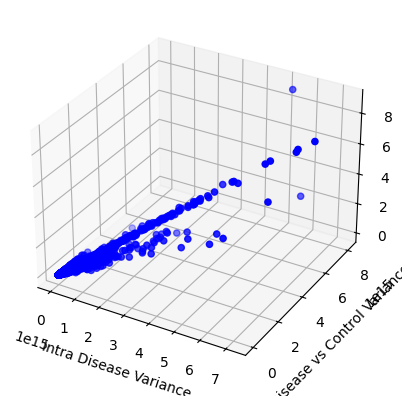

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set up a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Extract columns for plotting
x = variance_results["intra_disease_var"]
y = variance_results["disease_vs_control_var"]
z = variance_results["inter_disease_var"]

# Scatter plot
ax.scatter(x, y, z, c="b", marker="o")

# Set labels
ax.set_xlabel("Intra Disease Variance")
ax.set_ylabel("Disease vs Control Variance")
ax.set_zlabel("Inter Disease Variance")

Text(0.5, 1.0, 'Intra Disease Variance vs Inter Disease Variance\nPearson Correlation: 0.97')

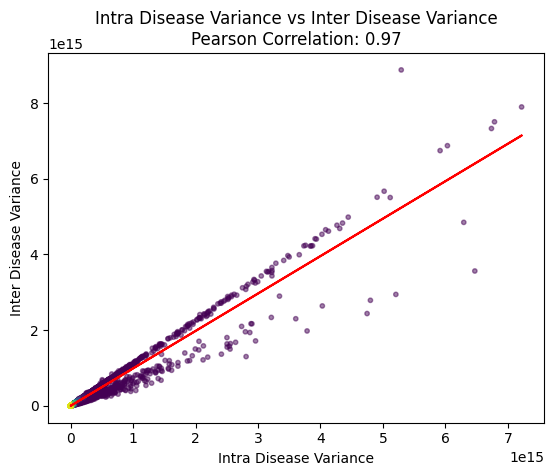

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Plot Gene Vairance vs Gene Presence


variance_results
variance_results_clean = variance_results.dropna()
y_data = variance_results_clean["inter_disease_var"]
x_data = variance_results_clean["intra_disease_var"]

# Calculate the point density
xy = np.vstack([x_data, y_data])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x_data, y_data, c=z, s=10, alpha=0.5)

# fit regression line
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(x_data, y_data)

plt.plot(
    x_data,
    slope * x_data + intercept,
    color="red",
    label=f"y = {slope:.2f}x + {intercept:.2f}",
)

plt.xlabel("Intra Disease Variance")
plt.ylabel("Inter Disease Variance")
plt.title(
    "Intra Disease Variance vs Inter Disease Variance\nPearson Correlation: {:.2f}".format(
        r_value
    )
)

In [47]:
mask = adata.obs["library"] == "Microarray"

sum_values = np.sum(~np.isnan(adata.X[mask]), axis=0)

sorted_sum_values = np.sort(sum_values)

sorted_sum_values[-500:]

array([11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380,
       11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380,
       11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380,
       11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380,
       11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380,
       11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380,
       11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380,
       11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380,
       11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380,
       11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380,
       11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380,
       11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380,
       11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380, 11380,
       11380, 11380, 11381, 11381, 11381, 11381, 11382, 11382, 11383,
       11383, 11383,

In [7]:
"""Compute variance for different groups
"""

# Assume 'adata' is your AnnData object, and it contains your expression data in 'adata.X'
# and disease labels and study labels in 'adata.obs'

# Step 1: Convert your gene expression matrix and disease labels to a pandas DataFrame
expr_data = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
disease_labels = adata.obs["disease"]
study_labels = adata.obs["disease_study"]


# Function to separate controls from the disease group based on your logic
def is_control(sample, disease_label):
    # Sample is a row from adata.obs
    return (sample["disease_study"] == disease_label) & (sample["disease"] == "Control")


def is_same_disease(sample, disease_label):
    return (sample["disease_study"] == disease_label) & (
        sample["disease"] == disease_label
    )


# Step 2: Create empty dataframes to store variance
variance_within_disease = pd.DataFrame(index=expr_data.columns)  # Genes as index
variance_disease_vs_control = pd.DataFrame(index=expr_data.columns)
variance_between_diseases = pd.DataFrame(index=expr_data.columns)

# Step 3: Iterate through each disease label
for disease_label in adata.obs["disease"].unique():
    if disease_label == "Control":
        continue  # Skip control group itself

    # Filter for disease group samples (excluding controls) and control samples
    disease_samples = adata.obs.apply(
        lambda x: is_same_disease(x, disease_label), axis=1
    )
    control_samples = adata.obs.apply(lambda x: is_control(x, disease_label), axis=1)

    # Subset the expression data for disease and control groups
    disease_expr = expr_data[disease_samples]
    control_expr = expr_data[control_samples]

    # Step 4: Intra-disease variance (excluding controls)
    if not disease_expr.empty:
        intra_var = disease_expr.var(axis=0)
        variance_within_disease[disease_label] = intra_var

    # Step 5: Disease vs control variance
    if not control_expr.empty:
        combined_expr = pd.concat([disease_expr, control_expr])
        disease_vs_control_var = combined_expr.var(axis=0)
        variance_disease_vs_control[disease_label] = disease_vs_control_var

# Step 6: Compute variance between diseases (excluding controls)
for disease1 in adata.obs["disease"].unique():
    if disease1 == "Control":
        continue

    for disease2 in adata.obs["disease"].unique():
        if disease2 == "Control" or disease1 == disease2:
            continue

        # Filter disease samples for each disease
        disease1_samples = adata.obs.apply(
            lambda x: is_same_disease(x, disease1), axis=1
        )
        disease2_samples = adata.obs.apply(
            lambda x: is_same_disease(x, disease2), axis=1
        )

        disease1_expr = expr_data[disease1_samples]
        disease2_expr = expr_data[disease2_samples]

        if not disease1_expr.empty and not disease2_expr.empty:
            combined_expr = pd.concat([disease1_expr, disease2_expr])
            inter_disease_var = combined_expr.var(axis=0)
            variance_between_diseases[f"{disease1}_vs_{disease2}"] = inter_disease_var

# Step 7: Combine the results into a single DataFrame for analysis
variance_results = pd.concat(
    [
        variance_within_disease.mean(axis=1).rename("intra_disease_var"),
        variance_disease_vs_control.mean(axis=1).rename("disease_vs_control_var"),
        variance_between_diseases.mean(axis=1).rename("inter_disease_var"),
    ],
    axis=1,
)

# Display the final variance results
print(variance_results.head())

   intra_disease_var  disease_vs_control_var  inter_disease_var
0       1.861930e+13            1.662060e+13       2.622429e+13
1       5.829830e+14            4.593116e+14       8.113737e+14
2       1.999604e+13            1.994453e+13       2.781064e+13
3       1.249607e+14            2.181274e+14       1.685443e+14
4       7.416028e+13            1.693124e+14       1.031357e+14


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Plot Gene Vairance vs Gene Presence


variance_results_clean = variance_results.dropna()
y_data = variance_results_clean["inter_disease_var"]
x_data = variance_results_clean["intra_disease_var"]

# Calculate the point density
xy = np.vstack([x_data, y_data])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x_data, y_data, c=z, s=10, alpha=0.5)

# fit regression line
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(x_data, y_data)

plt.plot(
    x_data,
    slope * x_data + intercept,
    color="red",
    label=f"y = {slope:.2f}x + {intercept:.2f}",
)

plt.xlabel("Intra Disease Variance")
plt.ylabel("Inter Disease Variance")
plt.title(
    "Intra Disease Variance vs Inter Disease Variance\nPearson Correlation: {:.2f}".format(
        r_value
    )
)


plt.savefig(
    os.path.join(output_dir, "variance.intra_vs_inter.png"),
    dpi=300,
    bbox_inches="tight",
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Plot Gene Vairance vs Gene Presence


variance_results
variance_results_clean = variance_results.dropna()
y_data = variance_results_clean["inter_disease_var"]
x_data = variance_results_clean["disease_vs_control_var"]

# Calculate the point density
xy = np.vstack([x_data, y_data])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x_data, y_data, c=z, s=10, alpha=0.5)

# fit regression line
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(x_data, y_data)

plt.plot(
    x_data,
    slope * x_data + intercept,
    color="red",
    label=f"y = {slope:.2f}x + {intercept:.2f}",
)

plt.xlabel("Intra Disease Variance")
plt.ylabel("Disease-Control Variance")
plt.title(
    "Intra Disease Variance vs Disease-Control Variance\nPearson Correlation: {:.2f}".format(
        r_value
    )
)

plt.savefig(
    os.path.join(output_dir, "variance.intra_vs_control.png"),
    dpi=300,
    bbox_inches="tight",
)

## Testing area